# 　誤差逆伝播法

この章では、ニューラルネットワークの学習(訓練)において重要な役割を果たす誤差逆伝播法の解説を行う。

誤差逆伝播法は、その名の通りニューラルネットワークの誤差最小化において、
誤差を出力層から入力層に向かって逆伝播させることで、各層のパラメータの更新を行うアルゴリズムである。

誤差逆伝播法の解説は、連鎖律(chain rule)を用いたものと、計算グラフを用いたものが代表的なように思う。
前者は、理論的理解を深める上で重要であるし、後者は実装の理解を深める上で重要である。この資料では、両方の解説を行う。

## 表式の整理

まずは状況設定、以下で考えるニューラルネットワークの構造や各パラメータ等について整理しておこう。

- 入力: $x \in \mathbb{R}^{d}$
- 第$\ell$層のノード数: $n^{(\ell)}$
- 第$\ell$層の第$k$ノードに係る重み: $\boldsymbol{w}^{(\ell)}_k = \{ w^{(\ell)}_{ki}\}$ ($i$は一つ上流側のノードの足)
- 第$\ell$層のノードのバイアス: $\boldsymbol{b}^{(\ell)} = \{ b^{(\ell)}_{i} \}$
- 第$\ell$層の活性化関数: $f^{(\ell)}$
- 第$\ell$層の入力: $u^{(\ell)} = \boldsymbol{W}^{(\ell)}  \boldsymbol{z}^{(\ell-1)} + b^{(\ell)}$
- 第$\ell$層の出力: $z^{(\ell)} = f( \boldsymbol{W}^{(\ell)} \cdot \boldsymbol{z}^{(\ell-1)} + b^{(\ell)} )$
  なお、$W$は第$\ell$層の重み行列で、各行が各ノードの重みベクトルに対応する。

  $$
  \begin{align*}
  W^{(\ell)} = \begin{pmatrix}
    w^{(\ell)}_{11} & w^{(\ell)}_{12} & \cdots & w^{(\ell)}_{1n^{(\ell-1)}} \\
    w^{(\ell)}_{21} & w^{(\ell)}_{22} & \cdots & w^{(\ell)}_{2n^{(\ell-1)}} \\
    \vdots & \vdots & \ddots & \vdots \\
    w^{(\ell)}_{n^{(\ell)}1} & w^{(\ell)}_{n^{(\ell)}2} & \cdots & w^{(\ell)}_{n^{(\ell)}n^{(\ell-1)}}
  \end{pmatrix}
  \end{align*}
  $$

- 出力 $y \in \mathbb{R}^{m}$

入力と出力はそれぞれ$d,m$次元の実数値、隠れ層が$L$個ある全結合の基本的な構造を持ったニューラルネットワークとする。
第$\ell$層の第$k$ノードに着目した模式図を示そう。

![](pic/pic_ann_uandz.png)


今注目しているノードに対する入力$u^{\ell}_k$は、

$$
\begin{align*}
u^{\ell}_k = &
w^{(\ell)}_{k1} z^{(\ell-1)}_1 
+ w^{(\ell)}_{k2} z^{(\ell-1)}_2 + \cdots 
+ w^{(\ell)}_{kn} z^{(\ell-1)}_n + b^{(\ell)}_{k} = 
\bf{w}^{(\ell)}_{k} \cdot \bf{z}^{(\ell-1)} + b^{(\ell)}_{k} 
\end{align*}
$$

などとかける。これに活性化関数$f^{(\ell)}$を適用することで、第$\ell$層$k$番目の出力$z^{(\ell)}_k$が得られ、
以下これを下層へと伝搬していく。


入力$x \in \mathbb{R}^d$に対する、ニューラルネットワークの出力$\hat{y} = f(x) \in \mathbb{R}^m$は、ニューラルネットワーク内のパラメータ(重みとバイアス)に対する依存性を顕に書くと、$f(\{ \boldsymbol{w} \}, \{ \boldsymbol{b} \}, x)$と表現できる。
ここでは、複数のレイヤーがあることを想定して、$w$や$b$を集合のように中括弧内に書いた。

この出力に対して、対応する訓練データが$y$で表現されるとき、最も単純な誤差関数である二乗誤差は

$$
L(\{ \boldsymbol{w} \}, \{ \boldsymbol{b} \}, x) = (y - \hat{y})^2
$$

とかける。このとき、誤差を最小化する(≒ネットワークを訓練する)ことは、

$$
\frac{\partial L}{\partial w^{(\ell)}_{ki}} = 0, \frac{\partial L}{\partial b^{(\ell)}_k} = 0 
$$

などの解を見つけることと言い換えられる。ここで上付きの添字は第$l$層のパラメータであること、下付きの添字は$k$番目のノードに対応する重みやバイアスであることを示すためにつけた。
実際には、誤差関数は訓練データに対する和になるが、今は特にその点は気にしないことにする。

一般に、ニューラルネットワークの層が深くなればなるほど、入力層に近いパラメータに対する依存性は非自明なものになると考えられる。
そこで、一般に多層のニューラルネットワークに対して、パラメータの最適化を効率的に行うためのアルゴリズムが本章で解説する誤差逆伝播法(back propagation, バックプロパゲーション)である。

## 連鎖律を用いた説明

上の勾配の式は、誤差関数をパラメータで微分した表式になっている。
最も下流にあるとみなせる誤差関数に対する微分を考える前に、
まずは、局所的な勾配に着目してみよう。

例えば、第$\ell$層の第$k$ノードに対応する重みパラメータ$w^{(\ell)}_{ki}$をわずかに変化させたとき、
当該のノードに対する入力$u^{\ell}_k$がわずかに変更を受ける。
その結果、というように、下流へ伝搬される値がわずかに変化していく。

誤差関数に対する$w$の微分を、$L$に対する$u$の微分と$u$に対する$w$の微分の積として表現することができる:

$$
\frac{\partial L }{\partial w^{(\ell)}_{ki}} 
= \frac{\partial L }{\partial u^{(\ell)}_{k}} \frac{\partial u^{(\ell)}_{k}}{\partial w^{(\ell)}_{ki}}
$$

二番目の項は、$u^{(\ell)}_{k}$が$w^{(\ell)}_{ki}$に対して線形であることから、

$$
\frac{\partial u^{(\ell)}_{k}}{\partial w^{(\ell)}_{ki}} = z^{(\ell-1)}_i
$$

となり、順伝搬の際に計算した値をそのまま使うことができる残るは1番目の項で、

$$
\delta^{\ell}_{k} \equiv \frac{\partial L }{\partial u^{(\ell)}_{k}} 
$$
と書き直しておく。この$\delta$に対する漸化式を求めてみよう。

$$
\delta^{\ell}_{k} = \frac{\partial L }{\partial u^{(\ell)}_{k}}
= \sum_{j=1}^{n^{(\ell+1)}} \frac{\partial L }{\partial u^{(\ell+1)}_{j}} \frac{\partial u^{(\ell+1)}_{j}}{\partial u^{(\ell)}_{k}}
= \sum_{j=1}^{n^{(\ell+1)}} \delta^{\ell+1}_{j} \frac{\partial u^{(\ell+1)}_{j}}{\partial u^{(\ell)}_{k}}
$$

ここで、$\delta$で書き直した残りの部分は、

$$
u^{(\ell+1)}_{j} = \sum_{i=1}^{n^{(\ell+1)}} w^{(\ell+1)}_{ji} f^{(\ell+1)}(u^{(\ell)}_{i}) + b^{(\ell+1)}_{j}
$$

より、

$$
\frac{ \partial u^{(\ell+1)}_{j} }{ \partial u^{(\ell)}_{k} } 
= w^{(\ell+1)}_{jk} f^{(\ell+1)'}(u^{(\ell)}_{k})
$$

とかけるので、

$$
\delta^{\ell}_{k} 
= \sum_{j=1}^{n^{(\ell+1)}} \delta^{\ell+1}_{j} 
w^{(\ell+1)}_{jk} f^{(\ell+1)'}(u^{(\ell)}_{k})
$$

となる。さて、ニューラルネットワークの順伝播の式(バイアス項は落とそう)を書いてみると

$$
u^{(\ell+1)}_j = \sum_{i=1}^{n^{(\ell)}} w^{(\ell+1)}_{ji} f(u^{(\ell)}_i)
$$

となるが、この、$u$に活性化関数をかけて重みをかけて順伝播していく式とのアナロジーで、
$\ell+1$層から$\ell$層へ$w$と$f'$を重みとして$\delta$を(逆)伝播している式と理解できる。

この式から、下流(出力に近い層)から、上流に逐次的に積と和を計算していくだけで、
各層での入力$u$に対する誤差関数の微分が計算できることがわかる。
また、それぞれのステップで非自明な計算は、活性化関数の微分を計算することだけである。
仮に、活性化関数がReLUのように単純なものであれば、計算は非常に効率的に行えることもわかる。
※ReLUの微分は、入力が0より大きいとき1、そうでないとき0になることを思い出そう。

## 計算グラフを用いた説明

計算グラフは、計算の流れをグラフ構造で表現したものでニューラルネットワークと同じようにノードやノードを結ぶエッジによって表現される。
計算グラフを用いることで、誤差逆伝播法の理解をより直感的に行うことができる。

ニューラルネットワークを考える前に、簡単な計算を計算グラフで表現してみよう。

100円のりんごを２個買い、5円の袋と合わせて買ってくるおつかいを考えよう。
このとき、おつかいの費用を$y$とすると、当然$y = (100 \times 2 + 10) * 1.1 $となる。

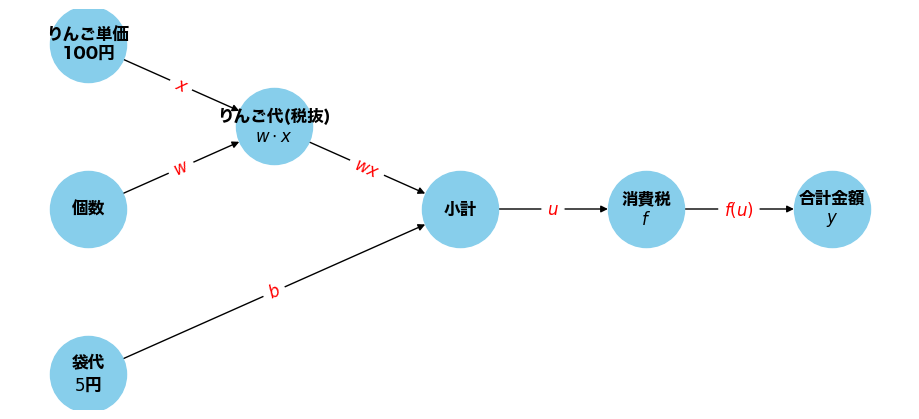

In [17]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a more detailed directed graph to include explicit operations
G_detailed = nx.DiGraph()

# Add nodes with their descriptions
nodes_detailed = {
    'x': 'りんご単価\n100円',
    'w': '個数',
    'wx': 'りんご代(税抜)\n$w\cdot x$',
    'b': '袋代\n$5$円',
    'sum': '小計',
    'activation': '消費税\n$f$',
    'y': '合計金額\n$y$'
}
G_detailed.add_nodes_from(nodes_detailed.keys())

# Add edges
edges_detailed = [('x', 'wx'), ('w', 'wx'), ('wx', 'sum'), ('b', 'sum'), ('sum', 'activation'), ('activation', 'y')]
G_detailed.add_edges_from(edges_detailed)

# Positioning for the nodes
pos_detailed = {
    'x': (0, 2),
    'w': (0, 1),
    'b': (0, 0),
    'wx': (1, 1.5),
    'sum': (2, 1),
    'activation': (3, 1),
    'y': (4, 1)
}

# Labels for the nodes
labels_detailed = {node: nodes_detailed[node] for node in G_detailed.nodes()}

# Labels for the edges
edge_labels_detailed = {
    ('x', 'wx'): '$x$',
    ('w', 'wx'): '$w$',
    ('wx', 'sum'): '$w x$',
    ('b', 'sum'): '$b$',
    ('sum', 'activation'): '$u$',
    ('activation', 'y'): '$f(u)$',
}

# Draw the graph
plt.figure(figsize=(9, 4))
nx.draw(G_detailed, pos_detailed, labels=labels_detailed, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_color='black', font_weight='bold', arrows=True, font_family='Hiragino Sans')
nx.draw_networkx_edge_labels(G_detailed, pos_detailed, edge_labels=edge_labels_detailed, font_size=12, font_color='red')
plt.show()

これは、りんご単価$x$が入力、個数が重みパラメータ$w$、袋代がバイアス$b$、消費税が活性化関数$f$のニューラルネットワークとみなすことができる。

単価$x$や個数$w$、袋代$b$が変わると当然合計の金額も変わる訳だが、
計算グラフの良いところは、これがりんご以外に様々な計算があったとしても、
卸売や小売のように多層であったりしても、興味のある部分だけを抜き出して考えることができる点にある。

これは、上で考えた様な、ニューラルネットワークにおける各ノードの計算を、
最終的な出力や誤差関数に対する微分の計算に利用する際にも有用である。

上の例で、合計金額に対するりんごの個数$w$や袋代$b$に対する微分を考えてみよう。

$$
\frac{\partial y}{\partial b} = \frac{\partial y}{\partial u} \frac{\partial u}{\partial b}
= f'(u) \times 1 = 1.1 \\
\frac{\partial y}{\partial w} = \frac{\partial y}{\partial u} \frac{\partial u}{\partial w}
= f'(u) \times x = 110
$$

このように、逆伝搬では、局所的な微分を乗算していくことで、各パラメータに対する微分を求めることができる。

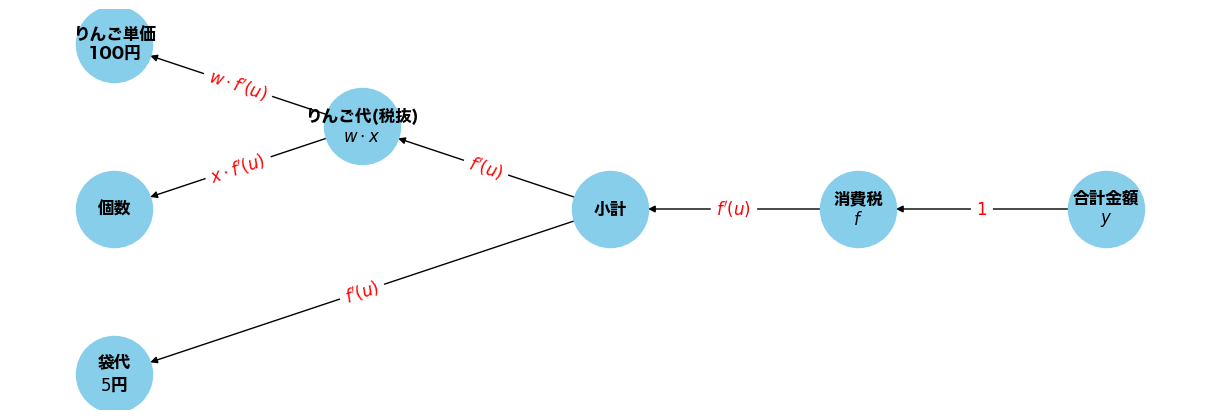

In [25]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a more detailed directed graph to include explicit operations
G_detailed = nx.DiGraph()

# Add nodes with their descriptions
nodes_detailed = {
    'x': 'りんご単価\n100円',
    'w': '個数',
    'wx': 'りんご代(税抜)\n$w\cdot x$',
    'b': '袋代\n$5$円',
    'sum': '小計',
    'activation': '消費税\n$f$',
    'y': '合計金額\n$y$'
}
G_detailed.add_nodes_from(nodes_detailed.keys())

# Add edges
edges_detailed = [('wx', 'x'), ('wx', 'w'), ('sum', 'wx'), ('sum', 'b'), ('activation','sum'), ('y','activation')]
G_detailed.add_edges_from(edges_detailed)

# Positioning for the nodes
pos_detailed = {
    'x': (0, 2),
    'w': (0, 1),
    'b': (0, 0),
    'wx': (1, 1.5),
    'sum': (2, 1),
    'activation': (3, 1),
    'y': (4, 1)
}

# Labels for the nodes
labels_detailed = {node: nodes_detailed[node] for node in G_detailed.nodes()}

# Labels for the edges
edge_labels_detailed = {
    ('wx', 'x'): "$w \cdot f'(u)$",
    ('wx', 'w' ): "$x \cdot f'(u)$",
    ('sum', 'wx'): "$f'(u)$",
    ('sum', 'b'): "$f'(u)$",
    ('activation', 'sum'): "$f'(u)$",
    ('activation', 'y'): '1',
}

# Draw the graph
plt.figure(figsize=(12, 4))
nx.draw(G_detailed, pos_detailed, labels=labels_detailed, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_color='black', font_weight='bold', arrows=True, font_family='Hiragino Sans')
nx.draw_networkx_edge_labels(G_detailed, pos_detailed, edge_labels=edge_labels_detailed, font_size=12, font_color='red')
plt.show()

ニューラルネットワークの場合、ある(ネットワークの意味での)ノードの順伝播は以下のように書くことができるが、
上と同様に、各計算グラフノードにおいて乗算すべき勾配を求めていくことで、
各パラメータに対する微分を効率的に計算することができる。

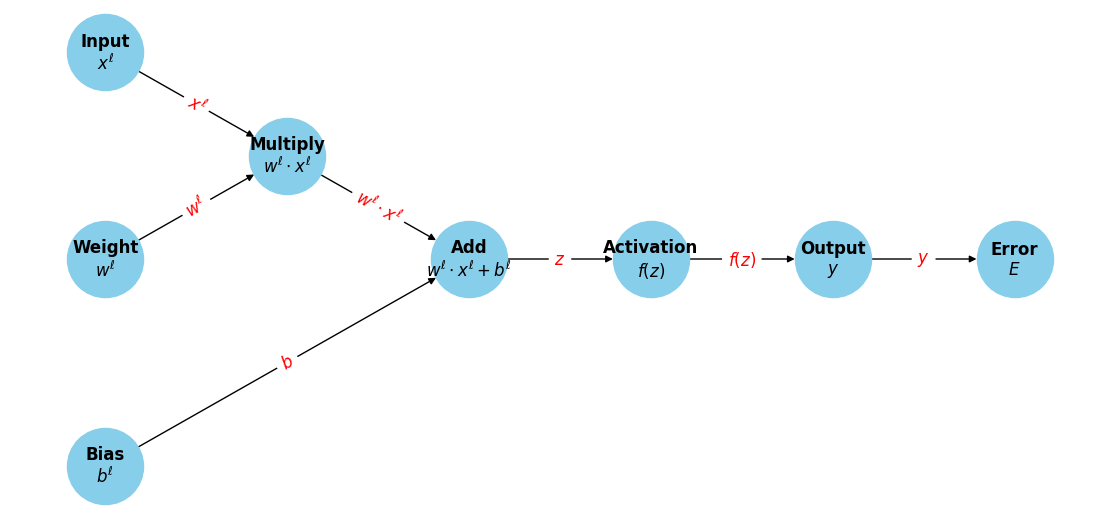

In [26]:
import matplotlib.pyplot as plt
import networkx as nx
# Create a more detailed directed graph to include explicit operations
G_detailed = nx.DiGraph()

# Add nodes with their descriptions
nodes_detailed = {
    'x': 'Input\n$x^{\ell}$',
    'w': 'Weight\n$w^{\ell}$',
    'b': 'Bias\n$b^{\ell}$',
    'mul': 'Multiply\n$w^{\ell} \cdot x^{\ell}$',
    'sum': 'Add\n$w^{\ell} \cdot x^{\ell} + b^{\ell}$',
    'activation': 'Activation\n$f(z)$',
    'y': 'Output\n$y$',
    'error': 'Error\n$E$'
}
G_detailed.add_nodes_from(nodes_detailed.keys())

# Add edges
edges_detailed = [('x', 'mul'), ('w', 'mul'), ('mul', 'sum'), ('b', 'sum'), ('sum', 'activation'), ('activation', 'y'), ('y', 'error')]
G_detailed.add_edges_from(edges_detailed)

# Positioning for the nodes
pos_detailed = {
    'x': (0, 2),
    'w': (0, 1),
    'b': (0, 0),
    'mul': (1, 1.5),
    'sum': (2, 1),
    'activation': (3, 1),
    'y': (4, 1),
    'error': (5, 1)
}

# Labels for the nodes
labels_detailed = {node: nodes_detailed[node] for node in G_detailed.nodes()}

# Labels for the edges
edge_labels_detailed = {
    ('x', 'mul'): '$x^{\ell}$',
    ('w', 'mul'): '$w^{\ell}$',
    ('mul', 'sum'): '$w^{\ell} \cdot x^{\ell}$',
    ('b', 'sum'): '$b$',
    ('sum', 'activation'): '$z$',
    ('activation', 'y'): '$f(z)$',
    ('y', 'error'): '$y$'
}

# Draw the graph
plt.figure(figsize=(11, 5))
nx.draw(G_detailed, pos_detailed, labels=labels_detailed, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_color='black', font_weight='bold', arrows=True)
nx.draw_networkx_edge_labels(G_detailed, pos_detailed, edge_labels=edge_labels_detailed, font_size=12, font_color='red')
plt.show()

## 誤差逆伝播法がなぜ重要なのか

ここまで読んできた人の中には、
>「誤差逆伝播法なんて考えなくても、パラメータを少しだけずらして、差分から勾配を計算すれば良いんじゃないのか？」

と考える人もいるかもしれない。確かに

$$
\frac{\partial L}{\partial w^{(\ell)}_{ki}} \approx 
\frac{ L(w^{(\ell)}_{ki} + \epsilon,...) - L(w^{(\ell)}_{ki},...)}{\epsilon}
$$
などとして、有限差分で勾配の値を見積もることはできる。ここで、注目する重み以外のパラメータは固定しているものとする。

一般に、ニューラルネットワークのパラメータ数は膨大であり、また、誤差関数も多くの訓練データに対して加算的に定義されるため、
このような方法では、計算量が膨大になってしまう。

:::{margin}
数値微分において、前方差分・中心差分・後方差分のいずれかを用いることができるが、
最も精度が良いのは中心差分である。しかし、中心差分を用いると、計算量は増えてしまう。
:::
上のように、いわゆる前方差分を用いた場合、右辺分子の第2項は一度順伝播の計算をするだけで使い回せるが、
第１項については、考えたいパラメータの数

$$
d n^{(1)} + \sum^L_{\ell=2} n^{(\ell)} n^{(\ell-1)} + n^L m
$$
だけ、同様の順伝播計算を行う必要がある。ここで、$d$は入力の次元、$n^{(\ell)}$は第$\ell$層のノード数、$m$は出力の次元である。
このような計算を行うのは非効率的である。

もちろん、数値差分は、正しく逆誤差伝播などの実装が行えているのか、機械学習フレームワークを正しく使えているのかなどを
チェックする際に有用になるが、実際のニューラルネットワークの学習においては、誤差逆伝播法を用いた方が、計算量の面ではるかに有利である。


### 余談: 自動微分

近年の深層学習の急速な発展において、様々なタスクに対応したり効率的に学習を進めるため、
多彩な活性化関数や最適化手法が提案されている、そのそれぞれや各項に対して、個別に誤差逆伝播法を実装するのは非常に大変である。

そこで、機械学習フレームワークでは、自動微分(automatic differentiation)という考え方が用いられており、
ユーザーが好きに定義したネットワーク構造や誤差関数についても、多くの場合、`loss.backward()`のような一行のコードで、誤差逆伝播法を実行することができる。

機械学習の中で行われる演算は上で見た計算グラフのように、加減乗除などの基本的な演算と、指数関数など基本的な関数の合成である。
自動微分は、こうした基礎的な演算で構成される合成写像に対して、系統的に微分を計算する方法を与えてくれる。

